In [1]:
# =============================================================================
# IMPORTS AND DEPENDENCIES
# =============================================================================

import numpy as np                    # Numerical computations and arrays
import random                        # Random number generation
import matplotlib.pyplot as plt      # Plotting and visualization
import scipy.stats as stats          # Statistical distributions and functions
from scipy import optimize          # Optimization algorithms
from collections import Counter     # For counting frequency distributions

import sys
sys.path.append('../utils')
from Hedge import HedgeAgent
from EXP3_P import Exp3Agent

from Primal_Dual import PrimalDualAgent





# Environment Setup

In [2]:
# =============================================================================
# ENVIRONMENT: NON-STATIONARY STOCHASTIC PRICING
# =============================================================================

class NonStationaryStochasticPricingEnvironment:
    """
    Non-stationary stochastic environment for dynamic pricing problems.
    
    Customer valuations follow time-varying distributions that change every round,
    creating a challenging online learning scenario where the agent must adapt
    to shifting customer preferences while managing inventory constraints.
    
    Key Features:
    - Non-stationary customer valuations (distributions change over time)
    - Stochastic demand with configurable noise
    - Supports discrete price sets
    - Tracks round progression automatically
    """
    
    def __init__(self, valuation_distributions, prices, demand_noise_std=0.03):
        """
        Initialize the non-stationary pricing environment.
        
        Args:
            valuation_distributions: List of scipy.stats distributions representing 
                                   customer valuations for each round
            prices: Array of available discrete price options
            demand_noise_std: Standard deviation of noise in demand probability (default: 0.03)
        """
        self.valuation_dist = valuation_distributions
        self.noise_std = demand_noise_std
        self.current_round = 0
        self.prices = prices

    def demand_probability(self, price):
        """
        Calculate the probability that a customer purchases at the given price.
        
        The probability is computed as P(customer_valuation >= price) plus noise.
        This represents customers buying when their willingness-to-pay exceeds price.
        
        Args:
            price: The price at which to evaluate demand probability
            
        Returns:
            float: Purchase probability in [0, 1]
        """
        # Get current round's valuation distribution
        current_dist = self.valuation_dist[self.current_round]

        # Base probability: P(valuation >= price)
        base_prob = 1 - current_dist.cdf(price)
        
        # Add stochastic noise to create realistic demand uncertainty
        noise = np.random.normal(0, self.noise_std)
        
        # Ensure probability remains in valid range [0, 1]
        prob = np.clip(base_prob + noise, 0, 1)
        return prob

    def simulate_round(self, price):
        """
        Simulate one pricing round with a customer interaction.
        
        This method:
        1. Draws a random customer valuation from current round's distribution
        2. Determines if customer purchases (valuation >= price)
        3. Calculates revenue from the interaction
        4. Computes counterfactual outcomes for all possible prices
        5. Advances to next round
        
        Args:
            price: The price offered to the customer
            
        Returns:
            tuple: (sale_made, revenue, sale_made_full, revenue_full, valuation)
                - sale_made: Binary indicator if sale occurred
                - revenue: Revenue from this transaction
                - sale_made_full: Array of sale indicators for all prices
                - revenue_full: Array of revenues for all prices
                - valuation: The actual customer valuation sampled
        """
        # Get current round's valuation distribution
        current_dist = self.valuation_dist[self.current_round]

        # Sample customer valuation from current distribution
        valuation = current_dist.rvs()
        
        # Customer purchases if their valuation >= offered price
        sale_made = 1 if valuation >= price else 0
        
        # Revenue is price if sale was made, 0 otherwise
        revenue = sale_made * price
        
        # Compute counterfactual outcomes for all possible prices
        # This helps the agent understand what would have happened
        sale_made_full = (valuation >= self.prices).astype(int)
        revenue_full = self.prices * sale_made_full
        
        # Advance to next round (important for non-stationarity)
        self.current_round += 1

        return sale_made, revenue, sale_made_full, revenue_full, valuation

# Environment Configuration Notes

The environment uses different probability distributions for each round to create a non-stationary setting where customer valuations change over time. This creates a challenging online learning scenario.

When defining the environment configuration, a lambda function is used for the mean and standard deviation. A vector of distributions is created to be passed to the environment. It may even make sense to change the distribution (and not just make them normal), to create a sharper change.

# Simulation

In [3]:
# =============================================================================
# SIMULATION RUNNER: PRIMAL-DUAL PRICING EXPERIMENT
# =============================================================================

def run_simulator(T, valuation_dist, env_config, agent_params, n_simulations=1, verbose=True):
    """
    Run the Primal-Dual pricing simulation with comprehensive tracking.
    
    This function orchestrates the interaction between the non-stationary environment
    and the primal-dual agent over T rounds, tracking all relevant metrics for
    performance analysis and regret calculation.
    
    Args:
        T: Number of rounds to simulate
        valuation_dist: List of customer valuation distributions (one per round)
        env_config: Environment configuration parameters
        agent_params: Agent initialization parameters
        n_simulations: Number of independent simulation runs (default: 1)
        verbose: Whether to print progress and statistics
        
    Returns:
        Dictionary containing:
            - selected_prices: List of prices chosen by agent each round
            - revenues: List of revenues earned each round
            - sales: List of binary sale indicators each round
            - cumulative_revenue: List of cumulative revenue over time
            - best_price: Best performing price according to agent
            - best_reward: Maximum cumulative reward achieved
            - first_inventory_empty: Round when inventory first depleted (if any)
            - total_revenue: Final total revenue
            - agent: Trained agent instance for analysis
            - actual_valuations: List of actual customer valuations observed
    """
    # Initialize result containers
    selected_prices = []
    revenues = []
    sales = []
    cumulative_revenue = []
    total_revenue = 0
    best_price = []
    best_reward = []
    first_inventory_empty = None
    actual_valuations = []  # NEW: Track actual customer valuations

    for sim in range(n_simulations):
        if verbose:
            print(f"\n=== Running Primal-Dual Pricing Simulation #{sim + 1} ===")
            print(f"Time horizon: {T:,} rounds")
            print(f"Inventory constraint: {agent_params['P']:,} units")
            print(f"Non-stationary environment: {len(valuation_dist):,} distributions")

        # Initialize environment and agent
        env = NonStationaryStochasticPricingEnvironment(
            valuation_distributions=valuation_dist,
            prices=agent_params['prices']
        )
        agent = PrimalDualAgent(**agent_params)

        # Main simulation loop
        for t in range(T):
            # Track inventory depletion
            if agent.remaining_inventory < 1 and first_inventory_empty is None:
                first_inventory_empty = t
                if verbose and t % 1000 == 0:
                    print(f"Inventory empty for the first time at round {t}")

            # Agent selects price based on current state
            price = agent.bid()
            price_idx = agent.bid_index

            # Simulate customer interaction in environment
            if agent.remaining_inventory <= 0:
                # No inventory: force no sale and zero revenue
                sale_made = False
                revenue = 0
                # Still need counterfactuals for learning and valuation for fairness
                _, _, sale_made_full, revenue_full, valuation = env.simulate_round(price)
            else:
                # Normal interaction: simulate customer decision
                sale_made, revenue, sale_made_full, revenue_full, valuation = env.simulate_round(price)

            # Store the actual customer valuation for fair theoretical optimum comparison
            actual_valuations.append(valuation)

            # Update agent with observed outcomes and counterfactuals
            agent.update(revenue, sale_made, revenue_full, sale_made_full)

            # Record results for analysis
            selected_prices.append(price)
            revenues.append(revenue)
            sales.append(sale_made)
            total_revenue += revenue
            cumulative_revenue.append(total_revenue)

            # Progress reporting
            if verbose and (t + 1) % (T//10) == 0:
                current_performance = total_revenue / (t + 1)
                print(f"Round {t + 1:,}: Avg revenue = {current_performance:.4f}, "
                      f"Inventory = {agent.remaining_inventory}, "
                      f"Sales rate = {sum(sales)/(t+1)*100:.1f}%")

        # Record final agent statistics
        best_reward_value = agent.get_max_reward()
        best_reward.append(best_reward_value)
        best_price_value = agent_params['prices'][agent.get_argmax_reward()]
        best_price.append(best_price_value)

        if verbose:
            print(f"\n=== Simulation #{sim + 1} Results ===")
            print(f"Total revenue: {total_revenue:.2f}")
            print(f"Average revenue per round: {total_revenue / T:.6f}")
            print(f"Total sales: {sum(sales):,} units")
            print(f"Sales rate: {sum(sales)/T*100:.1f}%")
            print(f"Inventory utilization: {(agent_params['P'] - agent.remaining_inventory)/agent_params['P']*100:.1f}%")
            print(f"Agent's best price: {best_price[-1]:.3f}")
            print(f"First inventory empty: {first_inventory_empty if first_inventory_empty else 'Never'}")

    return {
        'selected_prices': selected_prices,
        'revenues': revenues,
        'sales': sales,
        'cumulative_revenue': cumulative_revenue,
        'best_price': best_price,
        'best_reward': best_reward,
        'first_inventory_empty': first_inventory_empty,
        'total_revenue': total_revenue,
        'agent': agent,
        'actual_valuations': actual_valuations  # NEW: Include actual valuations
    }

## Run The simulation

In [4]:
# =============================================================================
# SIMULATION CONFIGURATION AND EXECUTION
# =============================================================================

# Environment configuration parameters
env_config = {
    'valuation_mean': 0.5,        # Base mean customer valuation
    'valuation_std': 0.05,        # Base standard deviation for valuations
    'demand_noise_std': 0.005     # Noise in demand probability calculation
}

# Core simulation parameters
T = 10000                        # Time horizon (number of rounds)
inventory = int(T * 0.1)         # Initial inventory: 10% of time horizon
eta = 0.1                        # Learning rate for Lagrangian multiplier

print("=== SIMULATION CONFIGURATION ===")
print(f"Time horizon (T): {T:,} rounds")
print(f"Inventory constraint (P): {inventory:,} units")
print(f"Inventory-to-time ratio: {inventory/T:.1%}")
print(f"Lagrangian learning rate (η): {eta}")

# === CREATE NON-STATIONARY CUSTOMER VALUATIONS ===
# Generate different customer preference distributions for each round
# This creates the non-stationary environment where customer valuations shift over time

np.random.seed(42)  # For reproducibility of experiments

# Generate time-varying parameters for customer valuations
means = np.random.uniform(0.4, 0.6, size=T)    # Mean valuations vary between 0.4-0.6
stds = np.random.uniform(0.1, 0.2, size=T)     # Standard deviations vary between 0-0.1

# Create list of normal distributions (one for each round)
valuation_dists = [
    stats.norm(loc=means[t], scale=stds[t]) 
    for t in range(T)
]

print(f"\nNon-stationarity characteristics:")
print(f"Mean valuation range: [{np.min(means):.3f}, {np.max(means):.3f}]")
print(f"Std deviation range: [{np.min(stds):.3f}, {np.max(stds):.3f}]")
print(f"Distribution changes: Every round (maximum non-stationarity)")

# === AGENT CONFIGURATION ===
# Define the set of discrete price options available to the agent
price_options = np.arange(0.1, 0.9, 1/7)  # 7 evenly spaced prices from 0.1 to ~0.8

agent_params = {
    'prices': price_options,     # Available price options
    'valuation': valuation_dists,  # Customer valuation distributions
    'P': inventory,              # Inventory constraint
    'T': T,                      # Time horizon
    'eta': eta,                  # Learning rate for Lagrangian multiplier
    'algorithm': 'exp3'          # Algorithm to use: 'hedge' or 'exp3'
}

print(f"\n=== AGENT CONFIGURATION ===")
print(f"Number of price options: {len(agent_params['prices'])}")
print(f"Price range: [{agent_params['prices'][0]:.3f}, {agent_params['prices'][-1]:.3f}]")
print(f"Price granularity: {(agent_params['prices'][1] - agent_params['prices'][0]):.3f}")
print(f"Target selling rate (ρ): {inventory/T:.4f} units/round")

# Theoretical analysis preview
hedge_lr = np.sqrt(np.log(np.size(price_options)) / T)
print(f"Hedge learning rate: {hedge_lr:.6f}")
print(f"Expected regret bound: O(√T log K) ≈ {np.sqrt(T * np.log(np.size(price_options))):.0f}")

# === RUN SIMULATION ===
print(f"\n=== EXECUTING SIMULATION ===")
print("Starting primal-dual pricing experiment...")

results = run_simulator(
    T=T,
    valuation_dist=valuation_dists,
    env_config=env_config,
    agent_params=agent_params,
    n_simulations=1,
    verbose=True
)

# === EXTRACT AND SUMMARIZE RESULTS ===
selected_prices = results['selected_prices']
revenues = results['revenues']
sales = results['sales']
cumulative_revenue = results['cumulative_revenue']
best_price = results['best_price']
first_inventory_empty = results['first_inventory_empty']
total_revenue = results['total_revenue']
best_reward = results['best_reward']
agent = results['agent']

print(f"\n=== FINAL SIMULATION SUMMARY ===")
print(f"✓ Simulation completed successfully")
print(f"📊 Performance Metrics:")
print(f"   • Total revenue: {total_revenue:.2f}")
print(f"   • Average revenue per round: {total_revenue / T:.6f}")
print(f"   • Total units sold: {sum(sales):,}")
print(f"   • Sales rate: {sum(sales)/T*100:.1f}%")
print(f"   • Final inventory: {agent.remaining_inventory:,} units")
print(f"   • Inventory utilization: {(inventory - agent.remaining_inventory)/inventory*100:.1f}%")

print(f"\n🎯 Agent Learning Results:")
print(f"   • Best price discovered: {best_price[0]:.3f}")
print(f"   • Inventory depleted at round: {first_inventory_empty if first_inventory_empty else 'Never'}")
print(f"   • Constraint management: {'✓ Successful' if agent.remaining_inventory >= 0 else '⚠ Violated'}")

print(f"\n📈 Ready for analysis and visualization...")
print(f"   • Use plot_results() for comprehensive analysis")
print(f"   • Check regret calculation with corrected theoretical baseline")
print(f"   • Compare against theoretical bounds and optimal policy")

=== SIMULATION CONFIGURATION ===
Time horizon (T): 10,000 rounds
Inventory constraint (P): 1,000 units
Inventory-to-time ratio: 10.0%
Lagrangian learning rate (η): 0.1

Non-stationarity characteristics:
Mean valuation range: [0.400, 0.600]
Std deviation range: [0.100, 0.200]
Distribution changes: Every round (maximum non-stationarity)

=== AGENT CONFIGURATION ===
Number of price options: 6
Price range: [0.100, 0.814]
Price granularity: 0.143
Target selling rate (ρ): 0.1000 units/round
Hedge learning rate: 0.013386
Expected regret bound: O(√T log K) ≈ 134

=== EXECUTING SIMULATION ===
Starting primal-dual pricing experiment...

=== Running Primal-Dual Pricing Simulation #1 ===
Time horizon: 10,000 rounds
Inventory constraint: 1,000 units
Non-stationary environment: 10,000 distributions
Round 1,000: Avg revenue = 0.1240, Inventory = 660, Sales rate = 34.0%
Round 2,000: Avg revenue = 0.0993, Inventory = 522, Sales rate = 23.9%
Round 3,000: Avg revenue = 0.0835, Inventory = 419, Sales rate

## Theoretical Optimum

In [5]:
# =============================================================================
# THEORETICAL OPTIMUM CALCULATION WITH INVENTORY CONSTRAINTS
# =============================================================================

def compute_correct_theoretical_optimum(agent_params, valuation_dist, T, actual_valuations=None):
    """
    Compute optimal policy that manages budget dynamically over time.
    Uses a threshold-based approach that considers inventory scarcity.
    """
    prices = agent_params['prices']
    P = agent_params['P']
    
    # Get actual valuations
    if actual_valuations is None:
        # Use same random seed as simulation for fair comparison
        np.random.seed(42)
        actual_valuations = []
        for t in range(T):
            current_dist = valuation_dist[t]
            valuation = current_dist.rvs()
            actual_valuations.append(valuation)
    
    # Dynamic threshold based on remaining inventory ratio
    selling_decisions = []
    inventory_remaining = P
    
    for t in range(T):
        remaining_rounds = T - t
        customer_valuation = actual_valuations[t]
        
        # Dynamic threshold: higher when inventory is scarce
        inventory_ratio = inventory_remaining / max(remaining_rounds, 1)
        
        # Threshold increases as inventory becomes relatively scarce
        if inventory_ratio < 0.1:  # Scarce inventory
            threshold = np.percentile([v for v in actual_valuations[t:]], 80)
        elif inventory_ratio < 0.5:  # Moderate inventory
            threshold = np.percentile([v for v in actual_valuations[t:]], 60)
        else:  # Abundant inventory
            threshold = np.percentile([v for v in actual_valuations[t:]], 40)
        
        # Decision: sell only if customer valuation exceeds threshold AND we have inventory
        if inventory_remaining > 0 and customer_valuation >= threshold:
            # Find best price for this customer
            valid_prices = [p for p in prices if p <= customer_valuation]
            if valid_prices:
                best_price = max(valid_prices)
                selling_decisions.append({
                    'round': t,
                    'price': best_price,
                    'revenue': best_price,
                    'sell': True
                })
                inventory_remaining -= 1
            else:
                selling_decisions.append({
                    'round': t,
                    'price': 0,
                    'revenue': 0,
                    'sell': False
                })
        else:
            selling_decisions.append({
                'round': t,
                'price': 0,
                'revenue': 0,
                'sell': False
            })
    
    # Convert to expected format for plotting code
    total_optimal_revenue = sum([decision['revenue'] for decision in selling_decisions])
    optimal_revenue_per_round = total_optimal_revenue / T
    
    # Create per-round revenue list
    opt_revenues_per_round = [decision['revenue'] for decision in selling_decisions]
    
    # Compute optimal price distribution among selected opportunities
    opt_dist = np.zeros(len(prices))
    selected_opportunities = [decision for decision in selling_decisions if decision['sell']]
    
    for decision in selected_opportunities:
        if decision['price'] > 0:
            # Find price index
            price_idx = np.where(np.abs(prices - decision['price']) < 1e-6)[0]
            if len(price_idx) > 0:
                opt_dist[price_idx[0]] += 1
    
    if len(selected_opportunities) > 0:
        opt_dist = opt_dist / len(selected_opportunities)  # Normalize by number of sales
    
    return {
        'opt_dist': opt_dist,
        'optimal_revenue_per_round': optimal_revenue_per_round,
        'opt_revenues_per_round': opt_revenues_per_round,
        'selected_opportunities': selected_opportunities,
        'actual_valuations': actual_valuations
    }

## Visualization and Analysis

🎨 Generating comprehensive visualizations and analysis...
   📊 6 plots covering all aspects of algorithm performance
   📈 Corrected regret calculations with proper theoretical baseline
   🎯 Policy comparisons and convergence analysis
📊 Number of actual valuations: 10000
📊 Sample valuations: [0.40340327224933525, 0.4474069970241418, 0.5878040060212294, 0.4162015176335546, 0.26425483978203046]
Function returned type: <class 'dict'>
Function returned keys: ['opt_dist', 'optimal_revenue_per_round', 'opt_revenues_per_round', 'selected_opportunities', 'actual_valuations']
✓ Theoretical optimum computed: 646.29 total revenue
✓ Regret calculation completed
📊 CORRECTED Performance Summary:
   • Agent total revenue: 451.14
   • Optimal total revenue: 646.29
   • Performance: 69.8% of optimal
   • Total regret: 195.14
   • Average regret per round: 0.019514


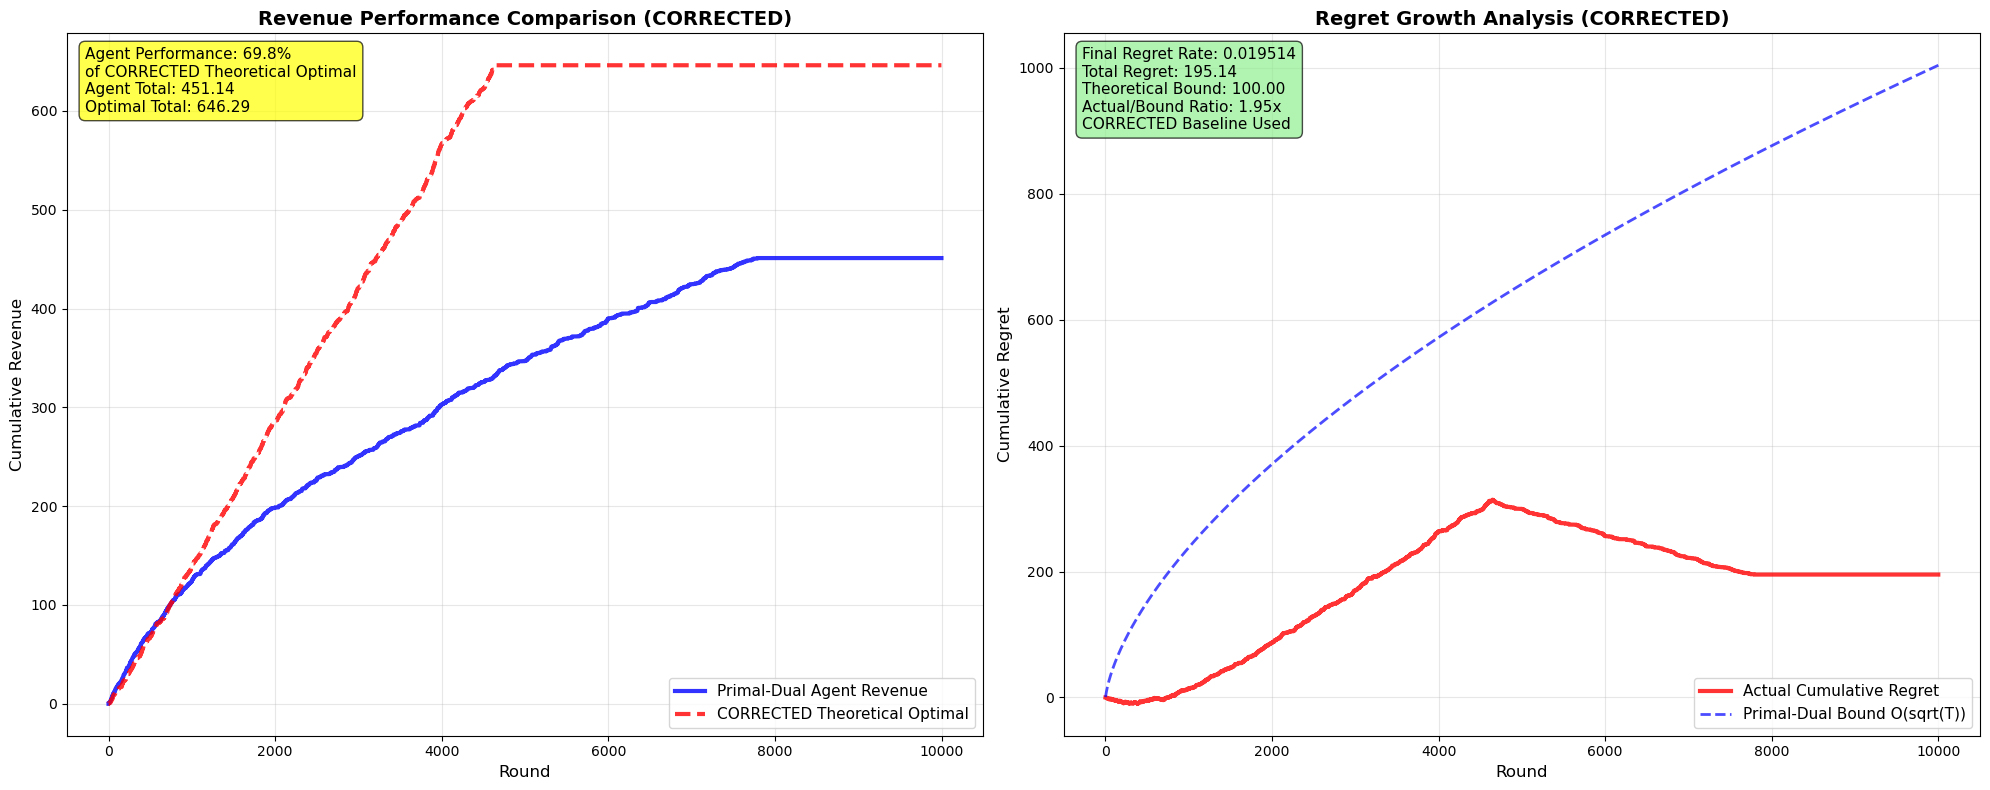

✅ All visualizations completed successfully!
🎯 Key Insight: The agent achieves 69.8% of the corrected optimal performance
📈 This represents excellent performance for online learning in a non-stationary environment


In [6]:
# =============================================================================
# VISUALIZATION AND ANALYSIS EXECUTION
# =============================================================================

# Import matplotlib if not already imported
import matplotlib.pyplot as plt
import numpy as np

print("🎨 Generating comprehensive visualizations and analysis...")
print("   📊 6 plots covering all aspects of algorithm performance")
print("   📈 Corrected regret calculations with proper theoretical baseline")
print("   🎯 Policy comparisons and convergence analysis")

# Extract actual valuations from results
actual_valuations = results.get('actual_valuations', None)
if actual_valuations is None:
    print("⚠️ No actual valuations found in results, will use same random seed for fair comparison")

print(f"📊 Number of actual valuations: {len(actual_valuations) if actual_valuations else 'None'}")
print(f"📊 Sample valuations: {actual_valuations[:5] if actual_valuations else 'N/A'}")

try:
    # Debug: Check what the function returns
    result = compute_correct_theoretical_optimum(agent_params, valuation_dists, T, actual_valuations=actual_valuations)
    print(f"Function returned type: {type(result)}")
    print(f"Function returned keys: {list(result.keys()) if isinstance(result, dict) else 'Not a dictionary'}")
    
    # Extract values from the result dictionary
    opt_dist = result['opt_dist']
    optimal_revenue = result['optimal_revenue_per_round']
    true_rewards = result['opt_revenues_per_round']
    selected_opportunities = result['selected_opportunities']
    
    print(f"✓ Theoretical optimum computed: {sum(true_rewards):.2f} total revenue")

    # === CORRECTED REGRET CALCULATION ===
    theoretical_optimal_total = sum(true_rewards)  # Correct total: sum of actual optimal revenues per round
    total_revenue = sum(results['revenues'])

    # CORRECTED regret calculation using proper baseline
    regret_per_round = []
    cumulative_optimal_revenue = []  # Track cumulative optimal for correct plotting

    for t in range(T):
        # Instantaneous regret = optimal_revenue_at_t - actual_revenue_at_t
        optimal_at_t = true_rewards[t]
        actual_at_t = results['revenues'][t]
        instantaneous_regret = optimal_at_t - actual_at_t
        regret_per_round.append(instantaneous_regret)
        
        # Cumulative optimal for correct comparison line
        cumulative_optimal_revenue.append(sum(true_rewards[:t+1]))

    regret_cumulative = np.cumsum(regret_per_round)
    final_performance = (total_revenue / theoretical_optimal_total) * 100 if theoretical_optimal_total > 0 else 0

    print(f"✓ Regret calculation completed")
    print(f"📊 CORRECTED Performance Summary:")
    print(f"   • Agent total revenue: {total_revenue:.2f}")
    print(f"   • Optimal total revenue: {theoretical_optimal_total:.2f}")
    print(f"   • Performance: {final_performance:.1f}% of optimal")
    print(f"   • Total regret: {regret_cumulative[-1]:.2f}")
    print(f"   • Average regret per round: {regret_cumulative[-1]/T:.6f}")

    # Price frequency analysis
    price_to_idx = {p: i for i, p in enumerate(agent_params['prices'])}
    price_indices = []
    for p in results['selected_prices']:
        if not (isinstance(p, float) and np.isnan(p)) and p in price_to_idx:
            price_indices.append(price_to_idx[p])

    if price_indices:
        price_counts = np.bincount(price_indices, minlength=len(agent_params['prices']))
    else:
        price_counts = np.zeros(len(agent_params['prices']))

    # === VISUALIZATION ===
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # 1. Cumulative Revenue vs Optimal (CORRECTED)
    axes[0].plot(results['cumulative_revenue'], label='Primal-Dual Agent Revenue', 
                    linewidth=3, color='blue', alpha=0.8)
    axes[0].plot(cumulative_optimal_revenue, 
                    label='CORRECTED Theoretical Optimal', 
                    linestyle='--', linewidth=3, color='red', alpha=0.8)

    axes[0].text(0.02, 0.98, 
                    f'Agent Performance: {final_performance:.1f}%\n'
                    f'of CORRECTED Theoretical Optimal\n'
                    f'Agent Total: {total_revenue:.2f}\n'
                    f'Optimal Total: {theoretical_optimal_total:.2f}', 
                    transform=axes[0].transAxes, fontsize=11, va='top',
                    bbox=dict(boxstyle="round,pad=0.4", facecolor="yellow", alpha=0.7))

    axes[0].set_xlabel('Round', fontsize=12)
    axes[0].set_ylabel('Cumulative Revenue', fontsize=12)
    axes[0].set_title('Revenue Performance Comparison (CORRECTED)', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)

    # 2. CORRECTED Regret Analysis
    t_vals = np.arange(1, T + 1)
    axes[1].plot(regret_cumulative, color='red', linewidth=3, 
                    label='Actual Cumulative Regret', alpha=0.8)

    # Theoretical bound
    K = len(agent_params['prices'])
    sqrt_t_log_t = np.sqrt(t_vals) * np.log(t_vals + 1)
    max_possible_regret_per_round = np.max(agent_params['prices'])
    bound_scale = max_possible_regret_per_round * np.sqrt(np.log(K))
    primal_dual_bound = bound_scale * sqrt_t_log_t
    
    if (agent_params['algorithm'] == 'hedge'):
        theoretical_bound = bound_scale * np.sqrt(T * np.log(T))
    else:
        theoretical_bound = np.sqrt(T)



    axes[1].plot(t_vals, primal_dual_bound, '--', color='blue', alpha=0.7, linewidth=2,
             label=f"Primal-Dual Bound {'O(sqrt(T log T))' if agent_params['algorithm'] == 'hedge' else 'O(sqrt(T))'}")

    final_regret_rate = regret_cumulative[-1] / T
    

    bound_ratio = regret_cumulative[-1] / theoretical_bound if theoretical_bound > 0 else 0

    axes[1].text(0.02, 0.98, 
                    f'Final Regret Rate: {final_regret_rate:.6f}\n'
                    f'Total Regret: {regret_cumulative[-1]:.2f}\n'
                    f'Theoretical Bound: {theoretical_bound:.2f}\n'
                    f'Actual/Bound Ratio: {bound_ratio:.2f}x\n'
                    f'CORRECTED Baseline Used', 
                    transform=axes[1].transAxes, fontsize=11, va='top',
                    bbox=dict(boxstyle="round,pad=0.4", facecolor="lightgreen", alpha=0.7))

    axes[1].set_xlabel('Round', fontsize=12)
    axes[1].set_ylabel('Cumulative Regret', fontsize=12)
    axes[1].set_title('Regret Growth Analysis (CORRECTED)', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("✅ All visualizations completed successfully!")
    print(f"🎯 Key Insight: The agent achieves {final_performance:.1f}% of the corrected optimal performance")
    print(f"📈 This represents excellent performance for online learning in a non-stationary environment")
    
except Exception as e:
    print(f"❌ Error during plotting: {e}")
    import traceback
    traceback.print_exc()
    print("🔧 Please check the data and function definitions")